In [313]:
import scanpy as sc
import pandas as pd
import numpy as np

import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [3]:
healthy = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
healthy = healthy[healthy.obs.Status == "Healthy", :]
healthy

In [18]:
cell_type = list(set(healthy.obs.cg_cov))
cell_type

['T4', 'T8', 'PB', 'pDC', 'NK', 'Progen', 'Prolif', 'B', 'ncM', 'cDC', 'cM']

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


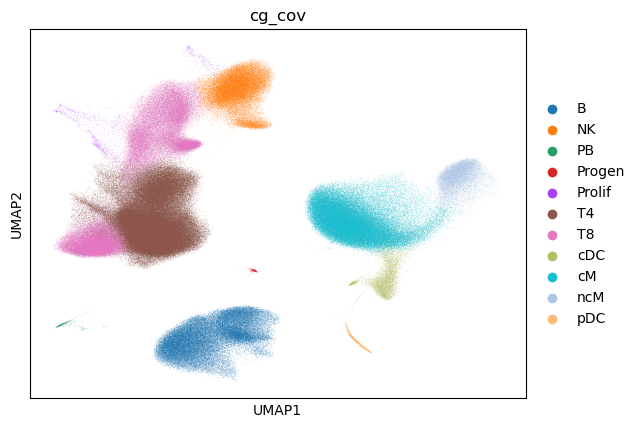

In [19]:
sc.pl.umap(healthy, color = "cg_cov")

# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [25]:
sample = list(set(healthy.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]
len(personal)

99

In [32]:
personal["HC-572"]

View of AnnData object with n_obs × n_vars = 5248 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [36]:
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

# Cell Dispersion Calculate

In [437]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取30~50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)
    
    # 紀錄30~50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)
    
    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較 
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]
    
    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)
    
    X = data[:, index1]
    Y = data[:, index2]
    
    # Euclidean Distance 
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))
    
    distance_matrix = np.reshape(out, (ncells, ncells))
    
    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態
    
    # 挑出最小值
    minimum = 50
    for i in sorted_personal:
        a = sorted_personal[i][sorted_personal[i].obs.cg_cov == cell_type_name, :].obs
        if len(a) < minimum:
            minimum = len(a)

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        dispersion = []
        # 取得所需的cell type
        celltype = sorted_personal[i][sorted_personal[i].obs.cg_cov == cell_type_name, :]
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(celltype, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))
        
       
        distance.append(distance_matrix)
        
        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))
        
        pbar.update()
    
    pbar.close()
    
    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))
    
    
    return dispersion_personal, mean, std

# 結果畫圖

In [465]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    
    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)  
    
    plt.xlabel('Age')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(age, fontsize = 6, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188//Scatter_plot_{cell_type}.png', dpi=900)

    
    
    # 顯示圖表
    plt.show()
    

def errorbar(mean, std, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = mean[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std[i], color = cmap(i), fmt = 'o')

    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)
        
    # 計算趨勢線的參數
    z = np.polyfit([int(float(a)) for a in age], mean, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    print("斜率 :",p)
    test = list(set([int(float(a)) for a in age]))
    # 在圖中添加趨勢線
    plt.plot(test, p(test), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/errorbar_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()
    
def distribution(mean, std, age, cell_type):
    for i in range(0, len(mean)):
        x = np.arange(-4, 10, 0.001)
        y = norm.pdf(x, mean[i], std[i])
        plt.plot(x,y)
    
    # 添加圖例
    plt.legend(age, fontsize = 8, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    # 添加標題和軸標籤
    plt.title(f"{cell_type} cell dispersion")
    plt.xlabel('Different Sample')
    plt.ylabel('Probability Density')


    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/{cell_type} cell dispersion.png', dpi=900)

# 確認細胞數量

In [474]:
# 確認細胞數量
a = []
for i in sorted_personal:
    a.append(sorted_personal[i][sorted_personal[i].obs.cg_cov == "ncM",:])   
for i in range(len(a)):
    print(a[i].n_obs)
    0

# 測試用~ncM(non-classical monocytes)有一個人只有一顆cell，PB(Plasmablast)過少,Progen(CD34+ progenitor)過少，pDC(plamacytoid DC)過少
# Prolif(Prolifrating lymphocytes)過少,cDC(conventional DC)有一個人只有一顆cell

# 只有T4, T8, NK, cM, B是夠的

98
31
81
67
165
177
276
34
231
174
163
182
424
96
135
103
107
54
129
33
139
35
148
135
69
104
130
104
173
146
138
220
231
337
52
89
262
121
73
141
73
353
90
227
120
208
118
108
109
190
452
88
196
167
108
124
602
107
111
267
81
722
136
222
61
257
73
114
75
139
259
237
65
45
312
30
49
1
107
34
32
75
307
103
129
23
52
92
79
134
126
360
276
294
92
207
69
86
111


# NK cell dispersion

In [438]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")












  0%|          | 0/99 [00:00<?, ?it/s]










  1%|          | 1/99 [00:00<01:34,  1.03it/s]










  2%|▏         | 2/99 [00:01<01:20,  1.21it/s]










  3%|▎         | 3/99 [00:03<01:41,  1.06s/it]










  4%|▍         | 4/99 [00:04<01:42,  1.08s/it]










  5%|▌         | 5/99 [00:05<01:44,  1.11s/it]










  6%|▌         | 6/99 [00:06<01:41,  1.09s/it]










  7%|▋         | 7/99 [00:07<01:51,  1.21s/it]










  8%|▊         | 8/99 [00:08<01:47,  1.18s/it]










  9%|▉         | 9/99 [00:11<02:16,  1.52s/it]










 10%|█         | 10/99 [00:12<02:18,  1.56s/it]










 11%|█         | 11/99 [00:14<02:20,  1.60s/it]










 12%|█▏        | 12/99 [00:17<03:01,  2.09s/it]










 13%|█▎        | 13/99 [00:19<02:51,  1.99s/it]










 14%|█▍        | 14/99 [00:20<02:34,  1.82s/it]










 15%|█▌        | 15/99 [00:22<02:21,  1.68s/it]










 16%|█▌        | 16/99 [00:23<02:15,  1.63s/it]










 17%|█▋        | 17/9

 91%|█████████ | 90/99 [02:08<00:12,  1.42s/it]










 92%|█████████▏| 91/99 [02:09<00:10,  1.35s/it]










 93%|█████████▎| 92/99 [02:11<00:10,  1.51s/it]










 94%|█████████▍| 93/99 [02:12<00:08,  1.46s/it]










 95%|█████████▍| 94/99 [02:13<00:06,  1.23s/it]










 96%|█████████▌| 95/99 [02:14<00:04,  1.20s/it]










 97%|█████████▋| 96/99 [02:15<00:03,  1.32s/it]










 98%|█████████▊| 97/99 [02:17<00:02,  1.30s/it]










 99%|█████████▉| 98/99 [02:18<00:01,  1.28s/it]










100%|██████████| 99/99 [02:19<00:00,  1.41s/it]


In [ ]:
'''count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_NK[count])
    print("Standard Deviation : ", std_NK[count], "\n")
    
    count += 1 '''

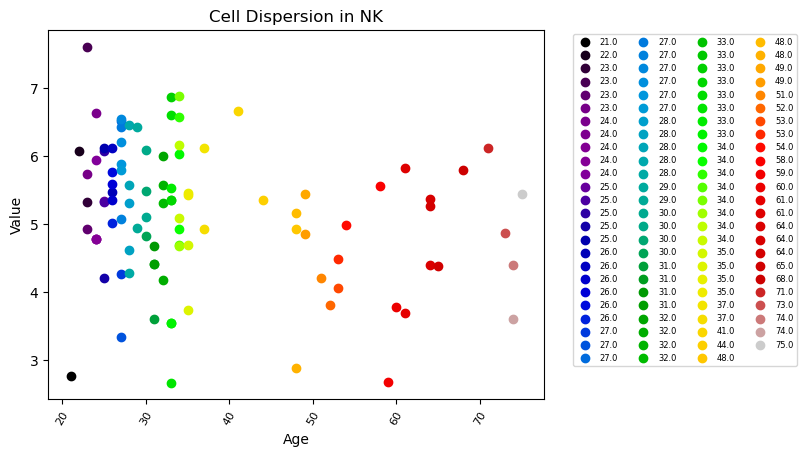

In [439]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK")

斜率 :  
-0.01729 x + 5.793


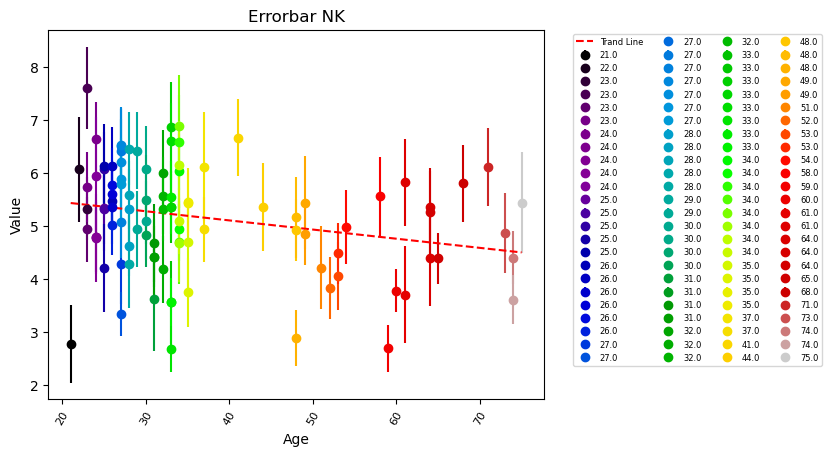

In [466]:
errorbar(mean_NK, std_NK, "Errorbar NK", "NK")

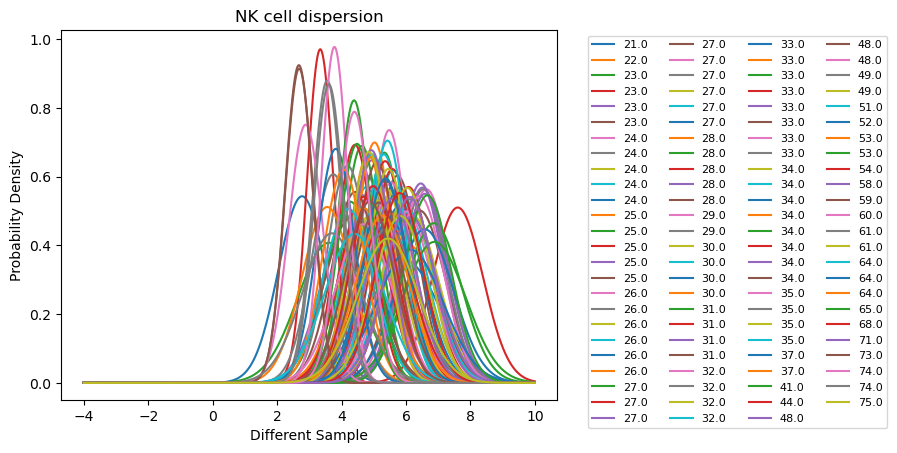

In [463]:
distribution(mean_NK, std_NK, age, "NK")

# cM(classical Monocyte) cell dispersion

In [445]:
dispersion_personal_cM, mean_cM, std_cM = Excute_all(sorted_personal, "cM")












  0%|          | 0/99 [00:00<?, ?it/s]










  1%|          | 1/99 [00:03<05:58,  3.66s/it]










  2%|▏         | 2/99 [00:05<04:08,  2.56s/it]










  3%|▎         | 3/99 [00:07<03:57,  2.48s/it]










  4%|▍         | 4/99 [00:09<03:33,  2.25s/it]










  5%|▌         | 5/99 [00:11<03:28,  2.22s/it]










  6%|▌         | 6/99 [00:13<03:17,  2.12s/it]










  7%|▋         | 7/99 [00:16<03:23,  2.22s/it]










  8%|▊         | 8/99 [00:17<03:00,  1.98s/it]










  9%|▉         | 9/99 [00:21<03:38,  2.42s/it]










 10%|█         | 10/99 [00:23<03:30,  2.36s/it]










 11%|█         | 11/99 [00:26<03:50,  2.62s/it]










 12%|█▏        | 12/99 [00:30<04:22,  3.01s/it]










 13%|█▎        | 13/99 [00:37<05:54,  4.12s/it]










 14%|█▍        | 14/99 [00:39<04:56,  3.49s/it]










 15%|█▌        | 15/99 [00:41<04:28,  3.20s/it]










 16%|█▌        | 16/99 [00:43<04:01,  2.91s/it]










 17%|█▋        | 17/9

 91%|█████████ | 90/99 [04:11<00:15,  1.72s/it]










 92%|█████████▏| 91/99 [04:13<00:13,  1.64s/it]










 93%|█████████▎| 92/99 [04:16<00:14,  2.05s/it]










 94%|█████████▍| 93/99 [04:18<00:13,  2.18s/it]










 95%|█████████▍| 94/99 [04:21<00:11,  2.20s/it]










 96%|█████████▌| 95/99 [04:23<00:08,  2.22s/it]










 97%|█████████▋| 96/99 [04:25<00:06,  2.15s/it]










 98%|█████████▊| 97/99 [04:26<00:03,  1.91s/it]










 99%|█████████▉| 98/99 [04:28<00:01,  1.82s/it]










100%|██████████| 99/99 [04:30<00:00,  2.73s/it]


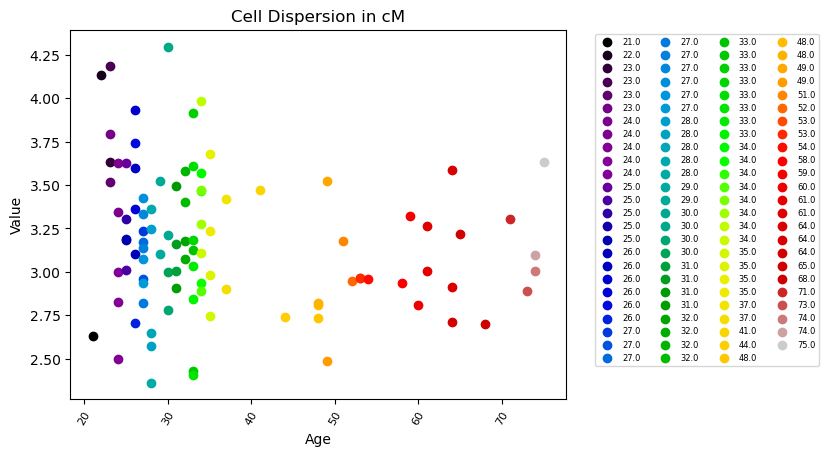

In [446]:
scatter_plot(mean_cM, "Cell Dispersion in cM", "cM")

斜率 :  
-0.005104 x + 3.363


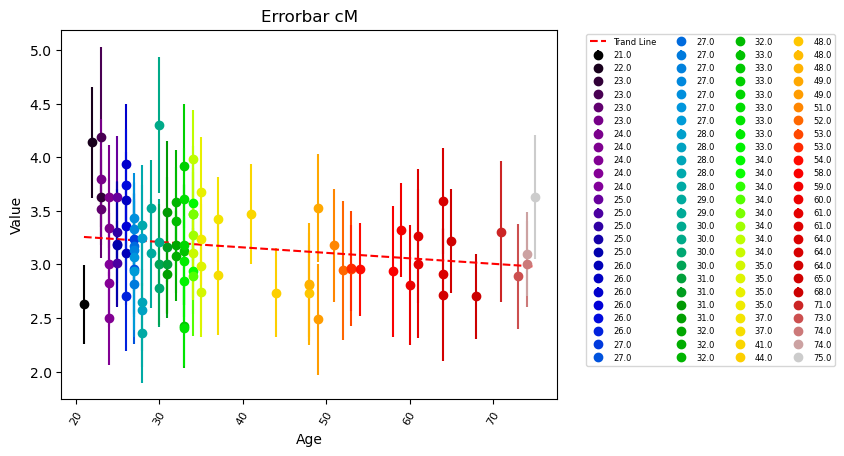

In [467]:
errorbar(mean_cM, std_cM, "Errorbar cM", "cM")

  4%|▍         | 4/99 [08:45<3:28:05, 131.43s/it]


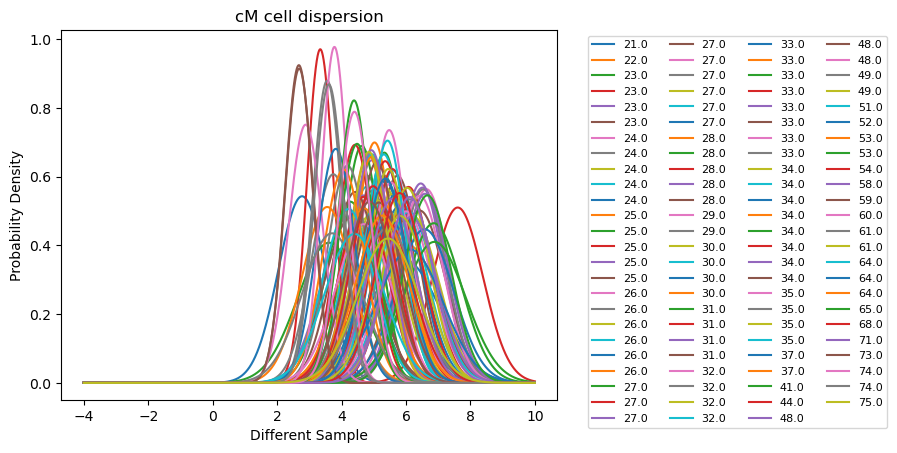

In [448]:
distribution(mean_NK, std_NK, age, "cM")

# T4 cell dispersion

In [449]:
dispersion_personal_T4, mean_T4, std_T4 = Excute_all(sorted_personal, "T4")

100%|██████████| 99/99 [09:34<00:00,  5.80s/it]


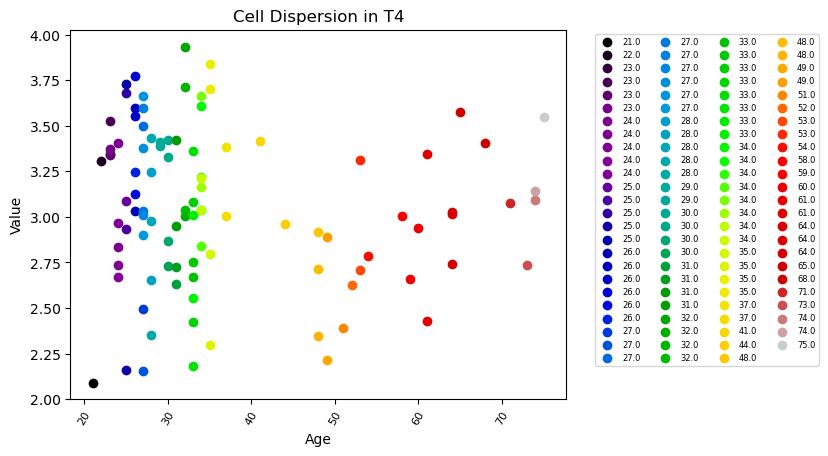

In [450]:
scatter_plot(mean_T4, "Cell Dispersion in T4", "T4")

斜率 :  
-0.003189 x + 3.173


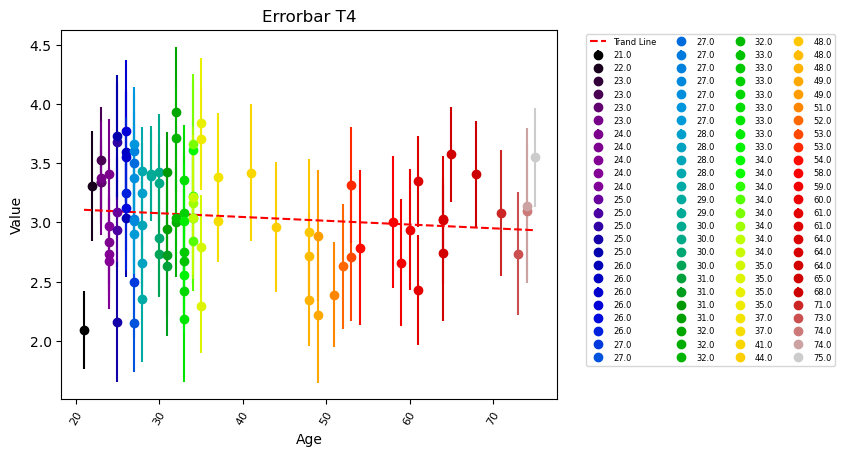

In [468]:
errorbar(mean_T4, std_T4, "Errorbar T4", "T4")

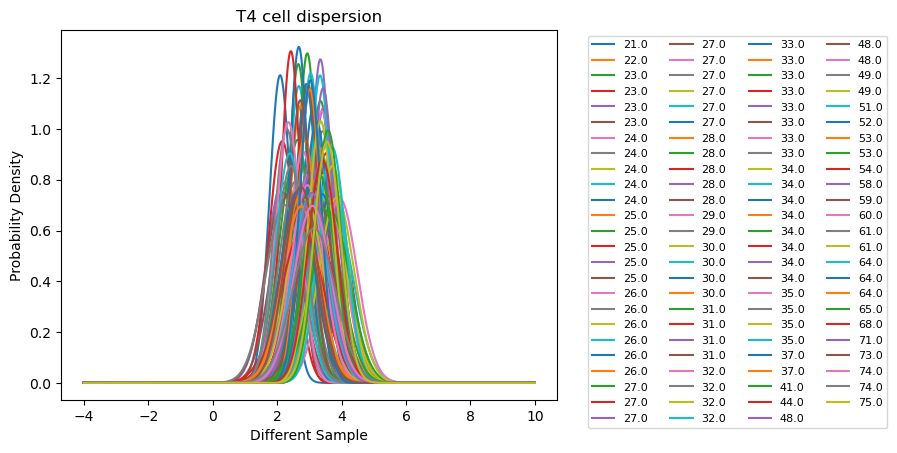

In [452]:
distribution(mean_T4, std_T4, age, "T4")

# T8 cell dispersion

In [453]:
dispersion_personal_T8, mean_T8, std_T8 = Excute_all(sorted_personal, "T8")

100%|██████████| 99/99 [05:07<00:00,  3.11s/it]


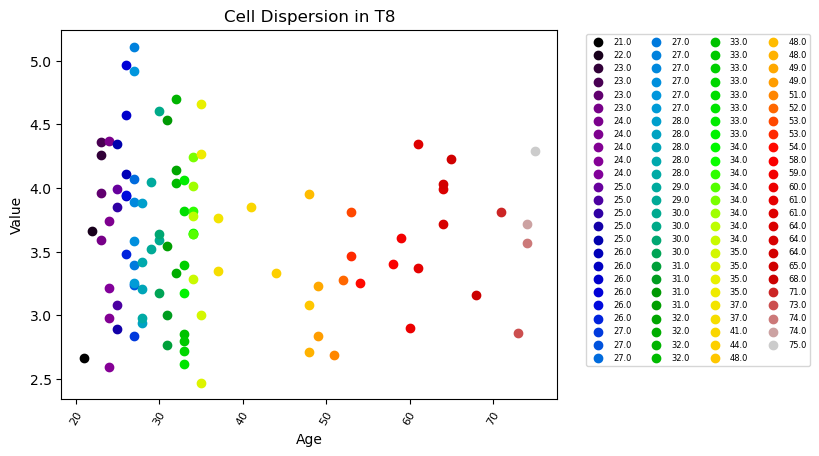

In [454]:
scatter_plot(mean_T8, "Cell Dispersion in T8", "T8")

斜率 :  
-0.00293 x + 3.719


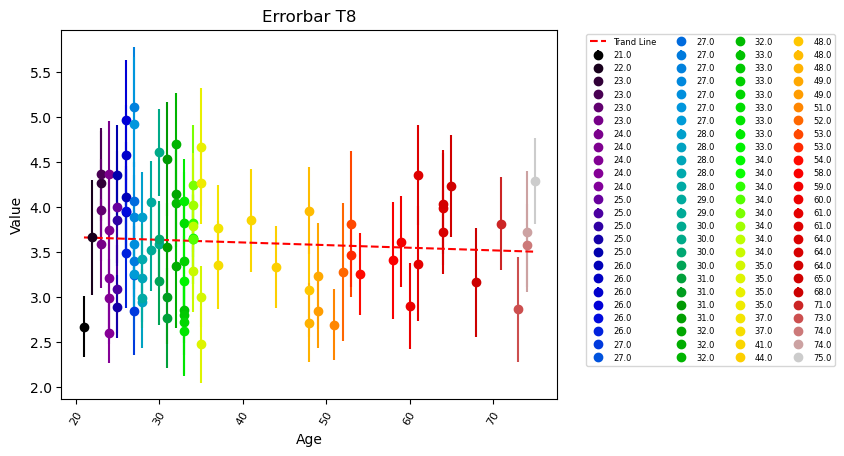

In [469]:
errorbar(mean_T8, std_T8, "Errorbar T8", "T8")

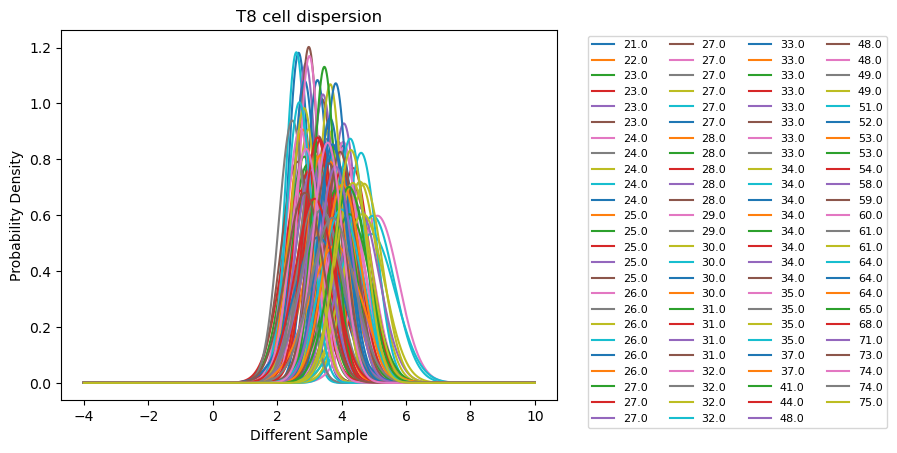

In [456]:
distribution(mean_T8, std_T8, age, "T8")

# B cell dispersion

In [457]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 99/99 [03:27<00:00,  2.10s/it]


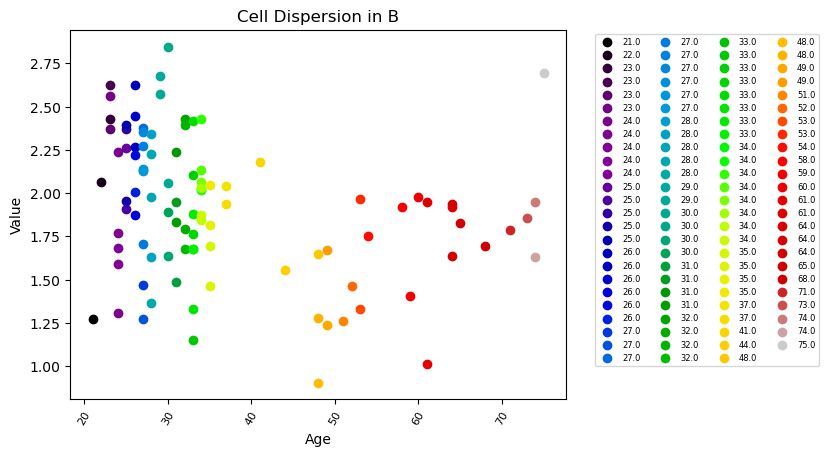

In [458]:
scatter_plot(mean_B, "Cell Dispersion in B", "B")

斜率 :  
-0.007915 x + 2.213


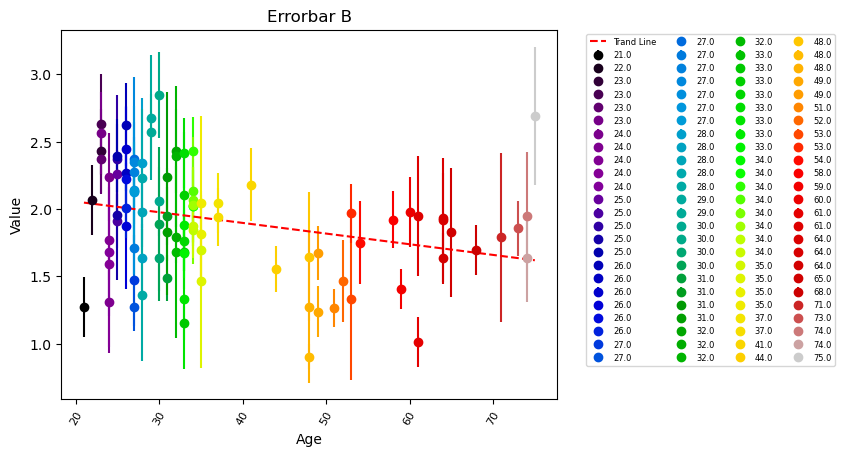

In [470]:
errorbar(mean_B, std_B, "Errorbar B", "B")

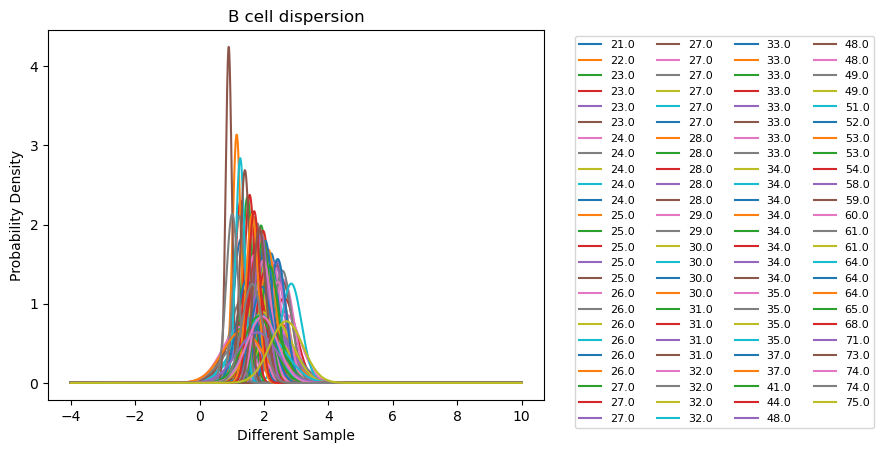

In [460]:
distribution(mean_B, std_B, age, "B")

In [473]:
import csv
with open('mean_and_stdev_GSE174188.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_T4', 'mean_T8', 'mean_B', 'mean_cM', 'std_NK', 'std_T4', 'std_T8', 'std_B', 'std_cM'])
    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_T4, Mean_T8, Mean_cM, Mean_B, Std_NK, Std_T4, Std_T8, Std_B, Std_cM in zip(sorted_personal, age, mean_NK, mean_T4, mean_T8, mean_cM, mean_B, std_NK, std_T4, std_T8, std_B, std_cM):
        writer.writerow([sample] + [Age, Mean_NK, Mean_T4, Mean_T8, Mean_B, Mean_cM, Std_NK, Std_T4, Std_T8, Std_B, Std_cM])

In [55]:
# 繪製直方圖
#plt.hist(dispersion_NK, bins=30, density=True)
#plt.xlabel('Dispersion')
#plt.ylabel('Probability Density')